In [80]:
! pip install nlpaug -q
! pip install fairseq -q
! pip install sacremoses -q
! pip install fastBPE -q
! pip install tqdm -q
! pip install pyprind -q
! pip install transformers -q 


In [81]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [82]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

from nlpaug.util import Action

import pandas as pd
import tqdm
import pickle
import pyprind 
import pandas as pd

## Data Preparation

In [83]:
df = pd.read_csv("/content/drive/MyDrive/END2.0/SentimentClassification/datasetSentences.txt", sep='\t' )

In [84]:
with open('/content/drive/MyDrive/END2.0/SentimentClassification/datasetSentences.txt') as f:
    lines = f.readlines()

dataset = [line.split('\t') for line in lines]  
dataset = pd.DataFrame(dataset, columns = ['num', 'text']) 
dataset = dataset.drop([0]) # dropping first row which is 'sentence_index" and "sentence" 
dataset = dataset.astype({'num': 'int64', 'text': 'string'})

In [85]:
with open('/content/drive/MyDrive/END2.0/SentimentClassification/sentiment_labels.txt') as f:
    lines = f.readlines()
    
dataset_label = [line.rstrip("\n").split("|") for line in lines]  
dataset_label = pd.DataFrame(dataset_label, columns = ['num', 'label'])
dataset_label = dataset_label.drop([0]) # dropping first row which is 'phrase ids" and "sentiment values" 
dataset_label = dataset_label.astype({'num': 'int64', 'label': 'float64'})

In [86]:
with open('/content/drive/MyDrive/END2.0/SentimentClassification/datasetSplit.txt') as f:
    lines = f.readlines()

dataset_split = [line.rstrip("\n").split(",") for line in lines]  
dataset_split = pd.DataFrame(dataset_split, columns = ['num', 'split'])
dataset_split = dataset_split.drop([0]) # dropping first row which is 'sentence_index' and "splitset_label" 
dataset_split = dataset_split.astype({'num': 'int64', 'split': 'int32'})
dataset_split.dtypes

num      int64
split    int32
dtype: object

In [87]:

dataset = dataset.merge(dataset_label, on='num',how='inner')
dataset = dataset.merge(dataset_split, on='num',how='inner')
dataset.head()

,num,text,label,split
0,1,The Rock is destined to be the 21st Century 's...,0.50000,1
1,2,The gorgeously elaborate continuation of `` Th...,0.44444,1
2,3,Effective but too-tepid biopic,0.50000,2
3,4,If you sometimes like to go to the movies to h...,0.42708,2
4,5,"Emerges as something rare , an issue movie tha...",0.37500,2


In [88]:
def binify(row):
  # print(row)
  bin = 5
  for i in range(bin):
    if i/bin <= row < (i+1)/bin:
      return i
    elif row == 1.0:
      return bin - 1

In [89]:
dataset['label_distint'] = dataset['label'].apply(binify)

dataset.label_distint.value_counts()

dataset[dataset.label_distint.isna()]

,num,text,label,split,label_distint


In [90]:
dataset.label_distint.value_counts()

2    6240
1    2175
3    2139
4     663
0     638
Name: label_distint, dtype: int64

In [91]:
dataset.head()

,num,text,label,split,label_distint
0,1,The Rock is destined to be the 21st Century 's...,0.50000,1,2
1,2,The gorgeously elaborate continuation of `` Th...,0.44444,1,2
2,3,Effective but too-tepid biopic,0.50000,2,2
3,4,If you sometimes like to go to the movies to h...,0.42708,2,2
4,5,"Emerges as something rare , an issue movie tha...",0.37500,2,1


In [92]:
dataset.to_csv("/content/drive/MyDrive/END2.0/SentimentClassification/stanfordSentimentTreebank_dataset.csv")

In [93]:
text = 'The quick brown fox jumps over the lazy dog .'
print(text)

The quick brown fox jumps over the lazy dog .


In [94]:

aug = naw.SynonymAug(aug_src='wordnet')
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)


Original:
The quick brown fox jumps over the lazy dog .
Augmented Text:
The quick brown fox spring over the indolent blackguard.


In [95]:
aug_del = naw.RandomWordAug()
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:
The quick brown fox jumps over the lazy dog .
Augmented Text:
The agile brown fox jump out over the lazy bounder.


In [98]:
# import nlpaug.augmenter.word as naw

# text = 'i am sleepig on the floor'
# back_translation_aug = naw.BackTranslationAug(
#     from_model_name='transformer.wmt19.en-de', 
#     to_model_name='transformer.wmt19.de-en'
# )
# augmented_text = back_translation_aug.augment(text)
# print("Original:")
# print(text)
# print("Augmented Text:")
# print(augmented_text)

In [99]:
aug = naf.Sometimes([
    aug
],aug_p=0.5, pipeline_p=0.5)

aug.augment(text, n=4)


['i am sleepig on the story',
 'i be sleepig on the floor',
 'i am sleepig on the base',
 'i am sleepig on the level']

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/END2.0/SentimentClassification/stanfordSentimentTreebank_dataset.csv")

In [100]:
dataset.columns

Index(['num', 'text', 'label', 'split', 'label_distint'], dtype='object')

In [101]:
(dataset.label_distint.value_counts())

2    6240
1    2175
3    2139
4     663
0     638
Name: label_distint, dtype: int64

In [102]:
df_n=dataset[dataset.label_distint==1].reset_index(drop=True)

In [103]:
import numpy as np
from tqdm import tqdm

def augment_text(df,samples=50,pr=0.2):
 
    new_text=[]
    for i in range(5):
    ##selecting the minority class samples
        df_n=df[df.label_distint==i].reset_index(drop=True)
        ## data augmentation loop
        print(np.random.randint(1,10,1))
        for j in tqdm(np.random.randint(0,len(df_n),samples)):
            
                text = df_n.iloc[j]['text']
                augmented_text = aug.augment(text)
                new_text.append(augmented_text)
        
        
        ## dataframe
        new=pd.DataFrame({'text':new_text,'label_distint':i})
        df=df.append(new).reset_index(drop=True)
    return df
   

train_ = augment_text(dataset)


100%|██████████| 50/50 [00:00<00:00, 290.51it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[8]
[7]



100%|██████████| 50/50 [00:00<00:00, 289.75it/s]

100%|██████████| 50/50 [00:00<00:00, 375.03it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[3]
[8]



100%|██████████| 50/50 [00:00<00:00, 352.23it/s]

100%|██████████| 50/50 [00:00<00:00, 346.11it/s]


[8]


In [104]:
# train_.label_distint.value_counts()

In [105]:
!nvidia-smi

Thu Jun 24 16:49:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [106]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))


Your runtime has 13.6 gigabytes of available RAM



# 0 TorchText

In [108]:
import pandas as pd
import pyprind
import os, pickle

## Dataset Preview

Your first step to deep learning in NLP. We will be mostly using PyTorch. Just like torchvision, PyTorch provides an official library, torchtext, for handling text-processing pipelines. 

We will be using previous session tweet dataset. Let's just preview the dataset.

## Preparing Dataset


In [18]:
dataset = pd.read_csv("/content/drive/MyDrive/END2.0/SentimentClassification/stanfordSentimentTreebank_dataset.csv")

## Defining Fields

Now we shall be defining LABEL as a LabelField, which is a subclass of Field that sets sequen tial to False (as it’s our numerical category class). TWEET is a standard Field object, where we have decided to use the spaCy tokenizer and convert all the text to lower‐ case.

In [109]:
# Import Library
import random
import torch, torchtext
from torchtext.legacy import data
import spacy
sp = spacy.load('en_core_web_sm')
import random

# Manual Seed
SEED = 43
torch.manual_seed(SEED)

all_stopwords = sp.Defaults.stop_words
print(len(all_stopwords))

326


In [110]:
train_df = dataset[dataset['split'] == 1].reset_index()
test_df = dataset[dataset['split'] == 2].reset_index()
val_df = dataset[dataset['split'] == 3].reset_index()


In [111]:
dataset_df = train_df.append(test_df).append(val_df).reset_index()

In [112]:
dataset_df.head()

,level_0,index,num,text,label,split,label_distint
0,0,0,1,The Rock is destined to be the 21st Century 's...,0.50000,1,2
1,1,1,2,The gorgeously elaborate continuation of `` Th...,0.44444,1,2
2,2,60,61,Singer\/composer Bryan Adams contributes a sle...,0.47222,1,2
3,3,61,62,You 'd think by now America would have had eno...,0.33333,1,1
4,4,62,63,Yet the act is still charming here .,0.31944,1,1


Having defined those fields, we now need to produce a list that maps them onto the list of rows that are in the CSV:

In [113]:
Text = data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True, stop_words = all_stopwords)
Label = data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

In [114]:
fields = [('text', Text),('labels',Label)]

Armed with our declared fields, lets convert from pandas to list to torchtext. We could also use TabularDataset to apply that definition to the CSV directly but showing an alternative approach too.

In [115]:
# train_example = pickle.load( 
#     open( "/content/drive/MyDrive/END2.0/SentimentClassification/train_examples.pkl", "rb" ) )
# val_example = pickle.load( 
#     open( "/content/drive/MyDrive/END2.0/SentimentClassification/val_examples.pkl", "rb" ) )
# test_example = pickle.load( 
#     open( "/content/drive/MyDrive/END2.0/SentimentClassification/test_examples.pkl", "rb" ) )


In [116]:
train_example = [data.Example.fromlist([dataset_df.text[i],dataset_df.label_distint[i]], fields) for i in range(dataset_df.shape[0])] 
# test_example = [data.Example.fromlist([test_df.text[i],test_df.label_distint[i]], fields) for i in range(test_df.shape[0])] 
# val_example = [data.Example.fromlist([val_df.text[i],val_df.label_distint[i]], fields) for i in range(val_df.shape[0])] 

In [117]:
dataset = data.Dataset(train_example, fields)
# test = data.Dataset(test_example, fields)
# valid = data.Dataset(val_example, fields)

In [118]:
(train, valid) = dataset.split(split_ratio=[70, 30], random_state = random.seed(SEED))

In [119]:
len(train), len(valid)

(8298, 3557)

An example from the dataset:

In [120]:
vars(train.examples[1])

{'labels': 2,
 'text': ['Instead',
  'building',
  'laugh',
  'riot',
  'left',
  'handful',
  'disparate',
  'funny',
  'moments',
  'real',
  'consequence',
  '.']}

## Building Vocabulary

At this point we would have built a one-hot encoding of each word that is present in the dataset—a rather tedious process. Thankfully, torchtext will do this for us, and will also allow a max_size parameter to be passed in to limit the vocabu‐ lary to the most common words. This is normally done to prevent the construction of a huge, memory-hungry model. We don’t want our GPUs too overwhelmed, after all. 

Let’s limit the vocabulary to a maximum of 5000 words in our training set:


In [121]:
MAX_VOCAB_SIZE = 17_000

Text.build_vocab(train, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.840B.300d")
Label.build_vocab(train)

In [122]:
Text.vocab.vectors.shape

torch.Size([16682, 300])

By default, torchtext will add two more special tokens, <unk> for unknown words and <pad>, a padding token that will be used to pad all our text to roughly the same size to help with efficient batching on the GPU.

In [123]:
print('Size of input vocab : ', len(Text.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Text.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  16682
Size of label vocab :  5
Top 10 words appreared repeatedly : [('.', 7806), (',', 7067), ('-', 2694), ('The', 1218), ('film', 1124), ('movie', 962), ('A', 825), ('`', 695), ('It', 655), ('...', 610)]
Labels :  defaultdict(None, {2: 0, 1: 1, 3: 2, 0: 3, 4: 4})


In [124]:
print(Text.vocab.itos[:10])

['<unk>', '<pad>', '.', ',', '-', 'The', 'film', 'movie', 'A', '`']


**Lots of stopwords!!**

Now we need to create a data loader to feed into our training loop. Torchtext provides the BucketIterator method that will produce what it calls a Batch, which is almost, but not quite, like the data loader we used on images.

But at first declare the device we are using.

In [125]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [126]:
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid), batch_size = 64, 
                                                            sort_key = lambda x: len(x.text),
                                                            sort_within_batch=True, device = device)

In [127]:
print('Train')
for batch in train_iterator:
    print(f'Text matrix size: {batch.text[0].size()}')
    print(f'Target vector size: {batch.labels.size()}')
    break
    
print('\nValid:')
for batch in valid_iterator:
    print(f'Text matrix size: {batch.text[0].size()}')
    print(f'Target vector size: {batch.labels.size()}')
    break
    


Train
Text matrix size: torch.Size([64, 6])
Target vector size: torch.Size([64])

Valid:
Text matrix size: torch.Size([64, 3])
Target vector size: torch.Size([64])


Save the vocabulary for later use

In [128]:

with open('/content/drive/MyDrive/END2.0/SentimentClassification/tokenizer.pkl', 'wb') as tokens: 
  pickle.dump(Text.vocab.stoi, tokens)

# with open('/content/drive/MyDrive/END2.0/SentimentClassification/train_examples.pkl', 'wb') as tokens: 
#     pickle.dump(train_example, tokens)

# with open('/content/drive/MyDrive/END2.0/SentimentClassification/val_examples.pkl', 'wb') as tokens: 
#     pickle.dump(val_example, tokens)

# with open('/content/drive/MyDrive/END2.0/SentimentClassification/test_examples.pkl', 'wb') as tokens: 
#     pickle.dump(test_example, tokens)




## Defining Our Model

We use the Embedding and LSTM modules in PyTorch to build a simple model for classifying tweets.

In this model we create three layers. 
1. First, the words in our tweets are pushed into an Embedding layer, which we have established as a 300-dimensional vector embedding. 
2. That’s then fed into a 2 stacked-LSTMs with 100 hidden features (again, we’re compressing down from the 300-dimensional input like we did with images). We are using 2 LSTMs for using the dropout.
3. Finally, the output of the LSTM (the final hidden state after processing the incoming tweet) is pushed through a standard fully connected layer with three outputs to correspond to our three possible classes (negative, positive, or neutral).

In [129]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True,
                           bidirectional= True)
        # try using nn.GRU or nn.RNN here and compare their performances
        # try bidirectional and compare their performances
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        # packed_output ,hidden = self.encoder(packed_embedded)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
        # print (output)
        return output

In [130]:
# Define hyperparameters
size_of_vocab = len(Text.vocab)
embedding_dim = 300
num_hidden_nodes = 16
num_output_nodes = 5
num_layers = 1
dropout = 0.5
PAD_IDX = Text.vocab.stoi[Text.pad_token]
# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [131]:
pretrained_embeddings = Text.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([16682, 300])


In [132]:
# model.embedding.weight.data = pretrained_embeddings.cuda()
model.embedding.weight.data.copy_(pretrained_embeddings)


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0120,  0.2075, -0.1258,  ...,  0.1387, -0.3605, -0.0350],
        ...,
        [ 0.0164, -0.1268,  0.1124,  ..., -0.0723,  0.4662, -0.3872],
        [-0.0592,  0.1091, -0.2313,  ...,  0.0914,  0.6806, -0.4423],
        [-0.3185, -0.0888,  0.0675,  ..., -0.2871,  0.6534, -0.5551]])

In [133]:

model.embedding.weight.data.shape

torch.Size([16682, 300])

In [134]:
UNK_IDX = Text.vocab.stoi[Text.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(embedding_dim)
model.embedding.weight.data[PAD_IDX] = torch.zeros(embedding_dim)

In [135]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(16682, 300)
  (encoder): LSTM(300, 16, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=16, out_features=5, bias=True)
)
The model has 5,045,389 trainable parameters


## Model Training and Evaluation

First define the optimizer and loss functions

In [136]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    # print (predictions, y)
    acc = correct.sum() / len(correct)
    return acc

def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    top_pred = preds.argmax(1, keepdim = True)
    # y_pred_tags = preds.argmax(dim=1) 
    # print(preds)
    # print(top_pred, y)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

The main thing to be aware of in this new training loop is that we have to reference `batch.tweets` and `batch.labels` to get the particular fields we’re interested in; they don’t fall out quite as nicely from the enumerator as they do in torchvision.

**Training Loop**

In [137]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    # set the model in training phase
    model.train()  
    bar = pyprind.ProgBar(len(iterator), bar_char='█')
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        text, text_lengths = batch.text   
        
        # convert to 1D tensor
        predictions = model(text, text_lengths).squeeze()  
        # print(list(predictions))
        # compute the loss
        loss = criterion(predictions, batch.labels)        
        
        # compute the category accuracy
        acc = categorical_accuracy(predictions, batch.labels)   
        true_y = F.one_hot(batch.labels, 5).to('cpu')
 
        f1_scr = f1_score(true_y, predictions.data.to('cpu') > 0.5, average="samples")
        # backpropage the loss and compute the gradients
        # print(epoch_f1)
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()  
        epoch_f1 += f1_scr 
        bar.update()
        # break
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1/ len(iterator)

**Evaluation Loop**

In [138]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            text, text_lengths = batch.text
            
            # convert to 1d tensor
            predictions = model(text, text_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.labels)
            acc = categorical_accuracy(predictions, batch.labels)
            true_y = F.one_hot(batch.labels, 5).to('cpu')
 
            f1_scr = f1_score(true_y, predictions.data.to('cpu') > 0.5, average="samples")
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_f1 += f1_scr
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1/ len(iterator)

**Let's Train and Evaluate**

In [139]:
from sklearn.metrics import classification_report, f1_score
N_EPOCHS = 5
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc, train_f1 = train(model, train_iterator, optimizer, criterion)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    # evaluate the model
    valid_loss, valid_acc, val_f1 = evaluate(model, valid_iterator, criterion)
    val_loss_list.append(valid_loss)
    val_acc_list.append(valid_acc)
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    print(f'\tEPOCH: {epoch}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% |  F1 Score: {train_f1}')

    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% |  F1 Score: {val_f1}')
    # break

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


	EPOCH: 0
	Train Loss: 1.571 | Train Acc: 40.34% |  F1 Score: 0.015865384615384615
	 Val. Loss: 1.494 |  Val. Acc: 53.26% |  F1 Score: 0.3714557191119691


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


	EPOCH: 1
	Train Loss: 1.446 | Train Acc: 52.16% |  F1 Score: 0.4883356227106227
	 Val. Loss: 1.409 |  Val. Acc: 53.31% |  F1 Score: 0.5261371862934363


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


	EPOCH: 2
	Train Loss: 1.406 | Train Acc: 52.28% |  F1 Score: 0.5197744963369964
	 Val. Loss: 1.390 |  Val. Acc: 53.31% |  F1 Score: 0.5328336148648648


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


	EPOCH: 3
	Train Loss: 1.395 | Train Acc: 52.30% |  F1 Score: 0.5222928113553114
	 Val. Loss: 1.384 |  Val. Acc: 53.31% |  F1 Score: 0.5328336148648648


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


	EPOCH: 4
	Train Loss: 1.390 | Train Acc: 52.33% |  F1 Score: 0.5229681776556777
	 Val. Loss: 1.380 |  Val. Acc: 53.31% |  F1 Score: 0.5331126327220077


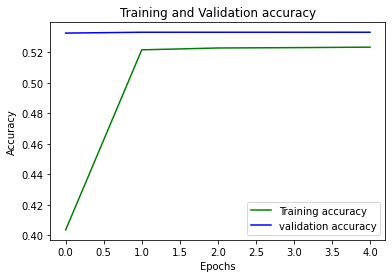

In [140]:
import matplotlib.pyplot as plt

loss_train = train_acc_list
loss_val = val_acc_list
epochs = range(0,N_EPOCHS)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Model Testing

In [145]:
path='./saved_weights.pt'
model.load_state_dict(torch.load(path))
model.eval()
test_loss, test_acc,test_f1 = evaluate(model, valid_iterator, criterion)
print(f'\t Test. Loss: {test_loss:.3f} |  Test. Acc: {test_acc*100:.2f}% |  Test. F1: {test_f1}\n')

	 Test. Loss: 1.380 |  Test. Acc: 53.31% |  Test. F1: 0.5331126327220077



In [146]:
#load weights and tokenizer

path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('/content/drive/MyDrive/END2.0/SentimentClassification/tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

def classify_tweet(tweet):
    # {2: 0, 1: 1, 3: 2, 4: 3, 0: 4}  very negative, negative, neutral, positive, very positive
    categories = {0:"neutral", 1:"negative",2: "positive", 3:"very positive", 4:"very negative" }
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    _, pred = torch.max(prediction, 1) 
    
    return categories[pred.item()]

In [147]:
dataset = pd.read_csv("/content/drive/MyDrive/END2.0/SentimentClassification/stanfordSentimentTreebank_dataset.csv")
test_df = dataset[dataset['split'] == 2].reset_index()
import numpy as np
categories = {0:"very negative", 1:"negative",2: "neutral", 3:"positive", 4:"very positive" }
trail = 9
list_rand = np.random.randint(1, test_df.shape[0], 10)
print(list_rand)
for index, i in test_df.iloc[list_rand].iterrows():
    # print(i)
    print("Sentence: ", i.text)
    print("True Label: ", categories[i.label_distint])
    print("Predicted: " ,classify_tweet(i.text))
    print("-"*25)

[1074 1145 2021 1915  274  173  671 1888 1215  891]
Sentence:  The film seems a dead weight .

True Label:  very negative
Predicted:  neutral
-------------------------
Sentence:  To imagine the life of Harry Potter as a martial arts adventure told by a lobotomized Woody Allen is to have some idea of the fate that lies in store for moviegoers lured to the mediocrity that is Kung Pow : Enter the Fist .

True Label:  neutral
Predicted:  neutral
-------------------------
Sentence:  It 's all very cute , though not terribly funny if you 're more than six years old .

True Label:  neutral
Predicted:  neutral
-------------------------
Sentence:  The story is less vibrant , the jokes are a little lukewarm , but will anyone really care ?

True Label:  neutral
Predicted:  neutral
-------------------------
Sentence:  Parker holds true to Wilde 's own vision of a pure comedy with absolutely no meaning , and no desire to be anything but a polished , sophisticated entertainment that is in love with 

## Discussion on Data Augmentation Techniques 

You might wonder exactly how you can augment text data. After all, you can’t really flip it horizontally as you can an image! :D 

In contrast to data augmentation in images, augmentation techniques on data is very specific to final product you are building. As its general usage on any type of textual data doesn't provides a significant performance boost, that's why unlike torchvision, torchtext doesn’t offer a augmentation pipeline. Due to powerful models as transformers, augmentation tecnhiques are not so preferred now-a-days. But its better to know about some techniques with text that will provide your model with a little more information for training. 

### Synonym Replacement

First, you could replace words in the sentence with synonyms, like so:

    The dog slept on the mat

could become

    The dog slept on the rug

Aside from the dog's insistence that a rug is much softer than a mat, the meaning of the sentence hasn’t changed. But mat and rug will be mapped to different indices in the vocabulary, so the model will learn that the two sentences map to the same label, and hopefully that there’s a connection between those two words, as everything else in the sentences is the same.

### Random Insertion
A random insertion technique looks at a sentence and then randomly inserts synonyms of existing non-stopwords into the sentence n times. Assuming you have a way of getting a synonym of a word and a way of eliminating stopwords (common words such as and, it, the, etc.), shown, but not implemented, in this function via get_synonyms() and get_stopwords(), an implementation of this would be as follows:


In [ ]:
def random_insertion(sentence, n): 
    words = remove_stopwords(sentence) 
    for _ in range(n):
        new_synonym = get_synonyms(random.choice(words))
        sentence.insert(randrange(len(sentence)+1), new_synonym) 
    return sentence

## Random Deletion
As the name suggests, random deletion deletes words from a sentence. Given a probability parameter p, it will go through the sentence and decide whether to delete a word or not based on that random probability. Consider of it as pixel dropouts while treating images.

In [ ]:
def random_deletion(words, p=0.5): 
    if len(words) == 1: # return if single word
        return words
    remaining = list(filter(lambda x: random.uniform(0,1) > p,words)) 
    if len(remaining) == 0: # if not left, sample a random word
        return [random.choice(words)] 
    else:
        return remaining

### Random Swap
The random swap augmentation takes a sentence and then swaps words within it n times, with each iteration working on the previously swapped sentence. Here we sample two random numbers based on the length of the sentence, and then just keep swapping until we hit n.

In [ ]:
def random_swap(sentence, n=5): 
    length = range(len(sentence)) 
    for _ in range(n):
        idx1, idx2 = random.sample(length, 2)
        sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1] 
    return sentence

For more on this please go through this [paper](https://arxiv.org/pdf/1901.11196.pdf).

### Back Translation

Another popular approach for augmenting text datasets is back translation. This involves translating a sentence from our target language into one or more other languages and then translating all of them back to the original language. We can use the Python library googletrans for this purpose. 

In [ ]:
import random
import googletrans
import googletrans.Translator

translator = Translator()
sentence = ['']

available_langs = list(googletrans.LANGUAGES.keys()) 
trans_lang = random.choice(available_langs) 
print(f"Translating to {googletrans.LANGUAGES[trans_lang]}")

translations = translator.translate(sentence, dest=trans_lang) 
t_text = [t.text for t in translations]
print(t_text)

translations_en_random = translator.translate(t_text, src=trans_lang, dest='en') 
en_text = [t.text for t in translations_en_random]
print(en_text)